# Salary Predictions Based on Job Descriptions

### Problem Definition

As a Data Scientist in the recruitment industry, my goal is to build a system to predict salaries for a new set of job postings based on data provided on a set of historic job postings that include salaries.

Two CSV data files are available as a basis for training a machine learning model:

• train_features.csv: Each row represents metadata for an individual job posting.
The “jobId” column represents a unique identifier for the job posting. The remaining columns describe features of the job posting.
• train_salaries.csv: Each row associates a “jobId” with a “salary”.

The data upon which predictions should be made are stored in a further CSV data file:

• test_features.csv: Similar to train_features.csv, each row represents metadata for an individual job posting.

The output of my system should be a CSV file entitled test_salaries.csv where each row has the following format:

jobId, salary

### Library Imports

In [23]:
# Importing base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Importing scikit-learn pre-processing libraries



# Importing scikit-learn machine learning libraries



# Author information
__author__ = "Ross MacDonald"
__email__ = "ross.macdonald@technologist.com"

 ### Reusable Functions

In [24]:
# Load CSV data file with completion dialogue and shape confirmation
def load_file(file):
    df =  pd.read_csv(file)
    shape = df.shape
    print("Data file is loaded, the shape of the dataset = {}".format(shape))
    return df

def ends(df, x):
    print('{} rows x {} columns'.format(np.shape(df)[0],np.shape(df)[1]))
    return df.head(x).append(df.tail(x))

### Load the Data

In [25]:
# Load the data into pandas dataframes (csv files for training and test data)
train_feature_df = load_file('data/train_features.csv')
train_target_df = load_file('data/train_salaries.csv')
test_df = load_file('data/test_features.csv')

Data file is loaded, the shape of the dataset = (1000000, 8)
Data file is loaded, the shape of the dataset = (1000000, 2)
Data file is loaded, the shape of the dataset = (1000000, 8)


In [26]:
# Merge the data on jobId to get a single training dataset (includes features and target)
train_df = pd.merge(train_feature_df,train_target_df,how="inner",on="jobId")

In [27]:
# Initial check of top 10 rows of train_df to confirm load and get an initial view on data / types
train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


In [28]:
# Initial check of top 10 rows of test_feature_df to confirm load and get an initial view on data / types
test_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


In [29]:
# Get information on the train_feature_df dataframe. Ensure data types and number of entries per column are as expected.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [30]:
# Get information on the train_feature_df dataframe. Ensure data types and number of entries per column are as expected.
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


### Clean the Data

In [31]:
# Check for duplicate rows in train_df
print("Number of duplicated rows = {}".format(train_df.duplicated().sum()))

Number of duplicated rows = 0


In [32]:
# Check for duplicate rows in train_df
print("Number of duplicated rows = {}".format(train_df.duplicated().sum()))

Number of duplicated rows = 0


In [33]:
# Check for null values in the columns of train_df
train_df.isnull().sum().to_frame('Null Entries')

,Null Entries
jobId,0
companyId,0
jobType,0
degree,0
major,0
industry,0
yearsExperience,0
milesFromMetropolis,0
salary,0


In [34]:
# Check for null values in the columns of test_df
test_df.isnull().sum().to_frame('Null Entries')

,Null Entries
jobId,0
companyId,0
jobType,0
degree,0
major,0
industry,0
yearsExperience,0
milesFromMetropolis,0


##### There are no duplicates or null entries in the data, so no need to drop rows / entries or subsitute any values. 

In [35]:
# Get the column names for numerical columns from train_df to enable us to filter for invalid values 
print(train_df.select_dtypes(include=['float64', 'int64']).columns.values)

['yearsExperience' 'milesFromMetropolis' 'salary']


In [36]:
# Having found the column names for numerical columns from train_df, find rows that contain invalid values (i.e. <0 or <=0)
print(train_df[(train_df['yearsExperience'] < 0) | (train_df['milesFromMetropolis'] < 0) | (train_df['salary'] <= 0)])

                   jobId companyId         jobType       degree        major  \
30559   JOB1362684438246    COMP44          JUNIOR     DOCTORAL         MATH   
495984  JOB1362684903671    COMP34          JUNIOR         NONE         NONE   
652076  JOB1362685059763    COMP25             CTO  HIGH_SCHOOL         NONE   
816129  JOB1362685223816    COMP42         MANAGER     DOCTORAL  ENGINEERING   
828156  JOB1362685235843    COMP40  VICE_PRESIDENT      MASTERS  ENGINEERING   

       industry  yearsExperience  milesFromMetropolis  salary  
30559      AUTO               11                    7       0  
495984      OIL                1                   25       0  
652076     AUTO                6                   60       0  
816129  FINANCE               18                    6       0  
828156      WEB                3                   29       0  


In [37]:
# Remove the rows that contain invalid data from the train_df dataframe (i.e. salary was invalid in all cases, thus only
# include rows with salaries more than 0)
train_df = train_df[train_df.salary > 0]

In [38]:
# Check dataframe information to confirm that the expected rows have been dropped
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [39]:
# Reset the index of train_df after dropping the invalid values and print head and tail (using function ends) to confirm
# reindex. Makes rows sequential to prevent any misunderstanding in subsequent analysis.
train_df = train_df.reset_index(drop=True)
ends(train_df, 3)

999995 rows x 9 columns


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


##### Invalid numerical entries have been dropped from the train_df dataframe, ensuring only valid data informs the prediction model / system. Index has been reset to prevent any misunderstanding (due to non-sequential rows in data) in any further analysis.

In [40]:
# Generate summary statistics for the training data train_df
train_df.salary.describe()

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

##### The summary 

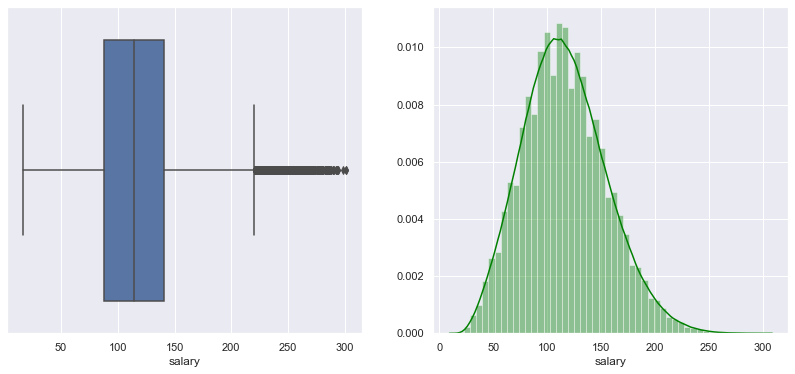

In [41]:
# Visualize target variable (salary)
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_df.salary)
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins=50 , color = 'green')
plt.show()

In [42]:
IQR = np.subtract(*np.percentile(train_df.salary, [75, 25]))
print(IQR)

53.0


In [43]:
df = train_df.salary[~((train_df.salary < (Q1 - 1.5 * IQR)) or (train_df.salary > (Q3 + 1.5 * IQR))).any()]
print (df)

NameError: name 'Q1' is not defined

### ---- 4 Explore the data (EDA) ----

In [ ]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data